In [3]:
import bioMass.dataViz as dv
from bioMass.dataloader import SentinelDataset, SentinelDataModule
from bioMass.model import Unet, DoubleStreamUnet
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
from torch import nn
import os
import numpy as np
import pandas as pd
from glob import glob
import yaml
import tifffile
from skimage import io
from joblib import Parallel, delayed


from pytorch_lightning import loggers as pl_loggers

%config Completer.use_jedi = False
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def load_UNetModel(logdir, DataParallel=False):
    "Returns loaded model from checkpoint and hyperparameters"
    if not logdir.endswith("/"):
        logdir = logdir + "/"

    with open(glob(logdir + "hparams.yaml")[0]) as f:
        hparams = yaml.load(f, Loader=yaml.BaseLoader)


    p = float(hparams["dropout_p"])  # dropout (zeroing) probability
    in_channels = int(hparams["in_channels"])
    init_n_features = int(hparams["init_n_features"])

    model = Unet(None, 0, init_n_features, in_channels, p)

    ckpt_file = glob(logdir + "checkpoints/*.ckpt")
    assert len(glob(logdir + "checkpoints/*.ckpt")) == 1
    ckpt_file = ckpt_file[0]

    model = model.load_from_checkpoint(ckpt_file).cuda()
    if DataParallel:
        model = torch.nn.DataParallel(model)

    return model, hparams

def load_DoubleStreamUnetModel(logdir, DataParallel=False):
    "Returns loaded model from checkpoint and hyperparameters"
    if not logdir.endswith("/"):
        logdir = logdir + "/"

    with open(glob(logdir + "hparams.yaml")[0]) as f:
        hparams = yaml.load(f, Loader=yaml.BaseLoader)
        
    p = float(hparams["dropout_p"])  # dropout (zeroing) probability

    model = DoubleStreamUnet(None, 0, p)

    ckpt_file = glob(logdir + "checkpoints/*.ckpt")
    assert len(glob(logdir + "checkpoints/*.ckpt")) == 1
    ckpt_file = ckpt_file[0]

    model = model.load_from_checkpoint(ckpt_file).cuda()
    if DataParallel:
        model = torch.nn.DataParallel(model)

    return model, hparams

In [7]:
dm = SentinelDataModule(max_chips=None, loader_type='PCA', is_train=False, loader_device='cpu', num_workers=24)
dm.setup('fit')

test_dataloader = dm.test_dataloader()

Test type specified, overriding split proportions to [0, 0, 1]


/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 0 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [8]:
logdir = '/home/ubuntu/Thesis/backup_data/bioMass_data/model_logs/pilot/DoubleStreamUNet/%s/version_1' %dm.loader_type

loss_module = nn.MSELoss(reduction='mean')
model = DoubleStreamUnet(loss_fn=loss_module, lr=1e-4, dropout_p=0.5)
model, hparams = load_DoubleStreamUnetModel(logdir)

/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(


# Check that chipids from dataloader correspond with the ones read directly from folder

In [5]:
idx = test_dataloader.dataset.indices
chip_ids = dm.dataset.tile_list[idx]

for i, sample in enumerate(tqdm(test_dataloader)):
    s1 = sample['image_s1'].to(model.device)
    s2 = sample['image_s2'].to(model.device)
    target = sample['label']
    batch_chips = chip_ids[i*dm.batch_size:min((i+1)*dm.batch_size, len(chip_ids))]
    break
    
# to check we are always loading the same values
sample['image_s1'].sum(), 'tensor(2.5629e+09)'

  0%|          | 0/87 [00:00<?, ?it/s]

(tensor(2.5629e+09), 'tensor(2.5629e+09)')

Text(0.5, 1.0, 'Dataloader')

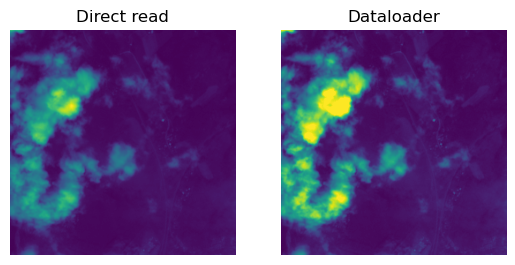

In [30]:
batch_idx = 10

file = "/home/ubuntu/Thesis/backup_data/bioMass_data/test_PCA_warm/%s_S2.tif" %batch_chips[batch_idx]

data = tifffile.imread(file)
data = torch.Tensor(np.float32(data))
data.shape

fig, ax = plt.subplots(1, 2)
[axi.set_axis_off() for axi in ax.ravel()]

ax[0].imshow(data[0].numpy())
ax[0].set_title('Direct read')
ax[1].imshow(s2[batch_idx].cpu().numpy()[0])
ax[1].set_title('Dataloader')

# Predict

In [5]:
def save_predictions(batch_chips, pred, folder):
    pred = np.float32(pred.detach().cpu().numpy())
    data = zip(batch_chips, pred)
    _ = Parallel(-1)(delayed(io.imsave)(f'{folder}/{chipid}_agbm.tiff', out, 'tifffile') for chipid, out in data)
    return

def compute_AGBMTest(test_dataloader, model, n_predictions=None):
    idx = test_dataloader.dataset.indices
    chip_ids = dm.dataset.tile_list[idx]
    
    for i, sample in enumerate(tqdm(test_dataloader)):
        s1 = sample['image_s1'].to(model.device)
        s2 = sample['image_s2'].to(model.device)
        target = sample['label']
        batch_chips = chip_ids[i*dm.batch_size:min((i+1)*dm.batch_size, len(chip_ids))]
        
        # keep dropout on for prediction
        if n_predictions is not None:
            model.train()
            with torch.no_grad():
                pred = torch.stack([model(s1, s2) for i in range(n_predictions)])
                pred = torch.mean(pred, axis=0)
            folder = '/home/ubuntu/Thesis/backup_data/bioMass_data/test_agbm_%i' %n_predictions
            
        else:
            model.eval()
            with torch.no_grad():
                pred = model(s1, s2)
            folder = '/home/ubuntu/Thesis/backup_data/bioMass_data/test_agbm'
        
        save_predictions(batch_chips, pred, folder)
        
    return batch_chips, pred

In [9]:
batch_chips, pred = compute_AGBMTest(test_dataloader, model)

  0%|          | 0/87 [00:00<?, ?it/s]

(array([4.28484e+05, 2.79973e+05, 3.10986e+05, 1.95629e+05, 9.75970e+04,
        4.34280e+04, 1.54590e+04, 3.95700e+03, 6.81000e+02, 6.20000e+01]),
 array([-32.06058121,  13.09221745,  58.24501801, 103.39781189,
        148.5506134 , 193.70341492, 238.85621643, 284.00900269,
        329.1618042 , 374.31460571, 419.46740723]),
 <BarContainer object of 10 artists>)

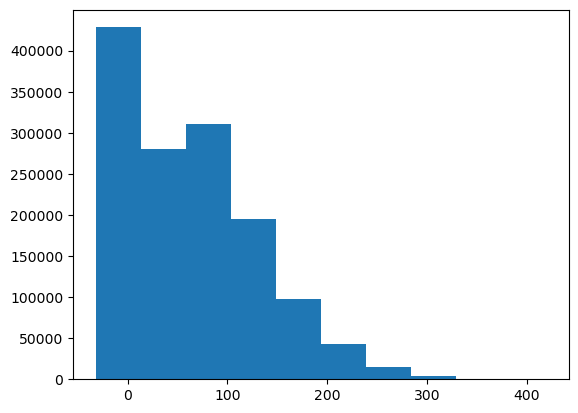

In [10]:
x = pred.detach().cpu().numpy()

plt.hist(x.flatten())